In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
# The usual notebook preferences

%config InlineBackend.figure_format = 'svg'

import numpy
import sys
import matplotlib.pyplot as plt

sys.path.append('..')
from helper_functions import *

HTML(toggle_code("import functions"))

In [3]:
set_notebook_preferences()

# 4. Dimensionality Reduction

In [classification](../classification/classification_intro.ipynb), we looked mainly at data with only a few variables per datapoints, such as the Iris dataset, which only has 4. However, in several applications, such as image classification the number of inputs per datapoint can be very large. For example, the images in the MNIST handwritten digits database are $28 \times 28$ pixel images, living in a $784$-dimensional space of pixel intensities. However, the MNIST images do not populate the whole space homogeneously but rather occupy a smaller subspace: although there is variability in the dataset due to different handwritings, slightly rotated characters and so on, the characters of a given class $(0, 1, 2 ..., 9)$ are somewhat similar to each other:

<div>
  <div class="column">
    <img src="mnist.svg" alt="Forest" style="width:40%; float: center; padding: 0px">
  </div>
</div>

Therefore not all pixel intensities are equally important in describing the MNIST dataset, because some images are never encountered and certain parts of the $784$-dimensional space are empty. Consider for example the first three images bellow, which are examples belonging to the same $784$-dimensional space as the MNIST images but which are very different to the images of the dataset.

<div class="row">
  <div class="column">
    <img src="dim_red_examples.svg" alt="Snow" style="width:75%; float: center; padding: 20px">
    <img src="dim_red_gaussian.svg" alt="Snow" style="width:40%; float: center; padding: 0px">
  </div>
</div>

To drive the point home with an example which can be visualised, the fourth image shows a $2$D dataset in which the points lie mostly along the direction of the arrow, and there is little variability along the direction perpendicular to the arrow.

There are two main issues which arise from this discussion. In high-dimensional datasets:

1. Certain directions of low variability may not be particularly informative about the data. For example, we could drop the direction perpendicular to the black arrow in the dataset above and still retain enough information to fit a simpler model to the now $1$D dataset. This is an example of data **pre-processing** which simplifies model fitting.

2. Finding the directions of highest variability may be a question in itself if we are trying to determine which features are important or unimportant for describing a particular dataset, potentially discarding the unimportant ones.

The above hint at two approaches for reducing number of dimensions of our dataset, which turn out to be equivalent. In the first approach we perform a basis change and then discard a number of dimensions of our dataset, picking the coordinate change and discarded dimensions so as to minimize the mean least-squares error from the unprocessed data $-$ this is the minimisation of mean reconstruction error formulation. In the second approach, we discard a number of dimensions of low data variance whilst keeping the highest variance ones $-$ this is the maximum variance formulation. This method of identifying the important directions in a dataset is called **principal component analysis** (PCA).

We will start with the minimisation of mean reconstruction error. Our aim is to represent each point on the dataset as some constant multiplied by the same vector $\mathbf{u}_1$. To do this, we first define a complete set of orthonormal basis vectors ${\mathbf{u}_d}$. Because these vectors are othonormal, it follows that each datapoint can be represented as a linear combination of these vectors:

$$
\mathbf{x}_n = \sum^D_{d = 1}a_{nd}\mathbf{u}_d
$$

Where $D$ is the number of dimensions in the dataset. Now let's take $M < D$ to be the number of dimensions we are reducing to (therefore $D-M$ is the number of dimensions we are removing ). We can now write:

$$
\mathbf{x}_n = \sum^M_{d = 1} a_{nd} \mathbf{u}_d +  \sum^D_{d = M + 1} a_{nd} \mathbf{u}_d
$$

The first sum here represents the orthogonal projection of the original datapoint onto the lower-dimensional subspace (as this can be expressed by the first $M$  basis vectors), and the second sum represents the vector between the original datapoint and the new datapoint. Now we need to define our error function. This is simply the Euclidean distance between the original and new datapoints. We can express this as:

\begin{align}
E &=  \sum^N_{n = 1}\bigg[\sum^D_{d = M + 1} a_{nd} \mathbf{u}_d\bigg]^\top \bigg[\sum^D_{d = M + 1} a_{nd} \mathbf{u}_d\bigg]\\
~\\
&=  \sum^N_{n = 1}\sum^D_{d = M + 1} a_{nd}^2\\
~\\
&=  \sum^N_{n = 1}\sum^D_{d = M + 1} (\mathbf{u}_d^\top (\mathbf{x}_n - \bar{\mathbf{x}}))((\mathbf{x}_n - \bar{\mathbf{x}})^\top\mathbf{u}_d)\\
~\\
&=  \sum^D_{d = M + 1} \mathbf{u}_d^\top \mathbf{S} \mathbf{u}_d\\
~\\
\end{align}

We want to minimize $E$ w.r.t. $\mathbf{u}_d$, however doing so directly would give the vacuous solution $\mathbf{u}_d = 0$, becuase we haven't constrained the magnitude of the basis vectors. Requiring $||\mathbf{u}_d|| = 1$ and using the method of Lagrange multipliers, we seek to minimise:

\begin{align}
E &= \bigg[\sum^D_{d = M + 1} \mathbf{u}_d^\top \mathbf{S} \mathbf{u}_d \bigg] - \lambda_d(\mathbf{u}_d^\top \mathbf{u}_d - 1)\\
~\\
\frac{\partial E}{\partial \mathbf{u}_d} &= 2\mathbf{S} \mathbf{u}_d - 2\lambda_d\mathbf{u}_d = 0\\
\end{align}

\begin{align}
\mathbf{S} \mathbf{u}_d = \lambda_d\mathbf{u}_d\\
\end{align}

The choice of dimensions which minimize the reconstruction loss are therefore eigenvectors of $\mathbf{S}$. In addition, each eigenvalue $\lambda_d$ is equal to the reconstruction loss due to discarding $\mathbf{u}_d$:

\begin{align}
\lambda_d &= \mathbf{u}_d^\top\mathbf{S}\mathbf{u}_d =  \frac{1}{N}\sum^N_{n = 1} \mathbf{u}_d^\top(\mathbf{x}_n - \bar{\mathbf{x}})(\mathbf{x}_n - \bar{\mathbf{x}})^\top \mathbf{u}_d\\
\implies \sum_{d = M +1}^D \lambda_d &= E =  \frac{1}{N}\sum_{d = M +1}^D\sum^N_{n = 1} \mathbf{u}_d^\top(\mathbf{x}_n - \bar{\mathbf{x}})(\mathbf{x}_n - \bar{\mathbf{x}})^\top \mathbf{u}_d\\
\end{align}

We can implement PCA by solving the eigenproblem $\mathbf{S} \mathbf{u}_d = \lambda_d\mathbf{u}_d$, and retaining the dimensions $\mathbf{u}_d$ with the highest eigenvalues $-$ discarding low eigenvalues means low reconstruction loss. Before that however, we will show the equivalence between reconstruction loss minimisation and variance maximisation. The latter amounts to selecting $M$ orthogonal directions such that the variance of the dataset in these directions is maximal:

\begin{align}
\text{Var}_{1:M}(\{\mathbf{x}\}) &=  \frac{1}{N}\sum^N_{n = 1}\bigg[\sum^M_{d = 1} a_{nd} \mathbf{u}_d \bigg]^2\\
~\\
&=  \frac{1}{N} \sum^N_{n = 1}\bigg[\sum^M_{d = 1} a_{nd} \mathbf{u}_d \bigg]^\top \bigg[\sum^M_{d = 1} a_{nd} \mathbf{u}_d \bigg]\\
\end{align}

The total variance of the dataset, $\text{Var}_{1:D}(\{\mathbf{x}\})$, can be expressed as

\begin{align}
\text{Var}_{1:D}(\{\mathbf{x}\}) &=  \frac{1}{N}\sum^N_{n = 1}\bigg[\sum^D_{d = 1} a_{nd} \mathbf{u}_d \bigg]^2\\
~\\
&=  \frac{1}{N}\sum^N_{n = 1}\Bigg[\bigg[\sum^M_{d = 1} a_{nd} \mathbf{u}_d \bigg]^2 + \bigg[\sum^D_{d = M + 1} a_{nd} \mathbf{u}_d \bigg]^2\Bigg]\\
~\\
&= \text{Var}_{1:M}(\{\mathbf{x}\}) + \text{Var}_{M:D}(\{\mathbf{x}\})\\
\end{align}

where we have used the orthogonality of the basis vectors $\mathbf{u}_d$, where we can read off that the second term $\text{Var}_{M:D}(\{\mathbf{x}\})$ is equal to the reconstruction loss found earlier. Considering that $\text{Var}_{1:D}(\{\mathbf{x}\})$ is constant and independent of the orientation of the basis, we see that maximizing the variance $\text{Var}_{1:M}(\{\mathbf{x}\})$ is equivalent to minimising the reconstruction loss $\text{Var}_{M:D}(\{\mathbf{x}\})$:

\begin{align}
\boxed{\text{Reconstruction loss minimisation}\Longleftrightarrow
\text{Variance maximisation}}
\end{align}

In [2]:
def PCA(x):
    
    S = ((x - x.mean()).T).dot(x - x.mean())/x.shape[0]
    eig_values, eig_vectors = np.linalg.eig(S)
    sort_idx = (-eig_values).argsort()
    eig_values, eig_vectors = eig_values[sort_idx], eig_vectors[:, sort_idx]
    
    return np.real(eig_values), np.real(eig_vectors)

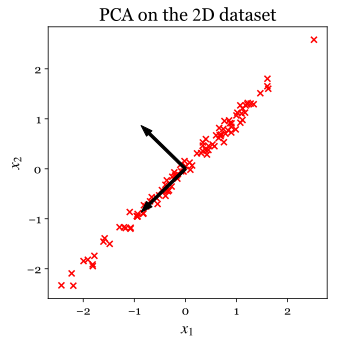

In [5]:
x = np.load('corr_data_2d.npy') # load the 2d correlated data from the example above
eig_values, eig_vectors = PCA(x) # perform PCA and return results

plt.figure(figsize = (5, 5))
plt.scatter(x[:, 0], x[:, 1], marker = 'x', color = 'red')
plt.arrow(0, 0, eig_vectors[0, 0], eig_vectors[0, 1], color = 'black', width = 0.05)
plt.arrow(0, 0, eig_vectors[1, 0], eig_vectors[1, 1], color = 'black', width = 0.05)
beautify_plot({"title":"PCA on the $2$D dataset", "x":"$x_1$", "y":"$x_2$"})
plt.show()

In [6]:
print(eig_values)

[ 2.08357687  0.00525835]


PCA gives the one independent component oriented along the long and one along the short axis of the gaussian, with correspondng variances $\approx 2.08 \text{ and } 0.0053$ respectively. The orientation of the components is just what we would expect from simply looking at the data. Now let's apply the same idea to MNIST:

In [7]:
x = np.load('mnist_images.npy') # load the MNIST images...
y = np.load('mnist_labels.npy') # ... and labels

X = x[np.where(y == 8)] # select all images of 8s
X = X.reshape((X.shape[0], -1)) # reshape images into vectors

eig_values, eig_vectors = PCA(X) # apply PCA

How is the reconstruction error affected by the number of components discarded in MNIST? Bellow we compute the mean reconstruction error due to discarding all components $(M+1), (M+2) ..., D$.

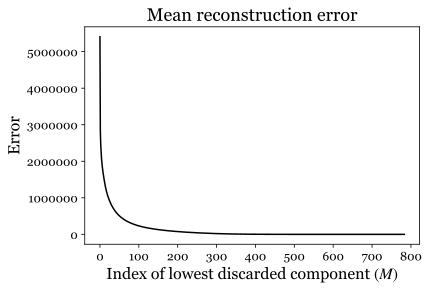

In [8]:
plt.plot(np.arange(eig_values.shape[0]), np.cumsum(eig_values[::-1])[::-1], color = 'black')
beautify_plot({"title":"Mean reconstruction error", "x":"Index of lowest discarded component $(M)$", "y":"Error"})
plt.show()

The reconstruction error appears to be dominated by a few components. These components are equivalently the direction of maximum variance, meaning that the images of $8$'s vary mostly along these directions. We will visualise these components bellow:

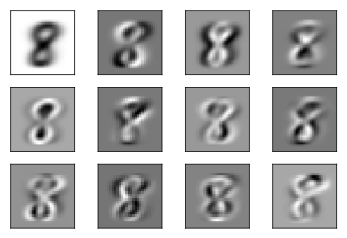

In [8]:
for i in range(12):
    
    plt.subplot(3, 4, i+1)
    plt.imshow(eig_vectors[:, i].reshape(x.shape[1:]), cmap = 'binary')
    remove_axes()
    
plt.show()

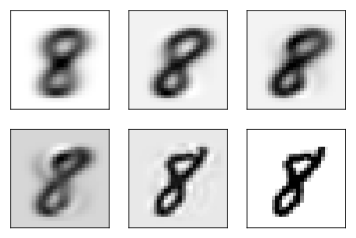

In [9]:
test_image = X[0]
inner_products = (eig_vectors.T).dot(test_image)
no_components = [1, 3, 5, 10, 100]

for i, n in enumerate(no_components):
    weights = inner_products[:n]
    vectors = eig_vectors[:, :n]
    reconstructed_img = vectors.dot(weights)
    
    plt.subplot(2, 3, i+1)
    plt.imshow(reconstructed_img.reshape(x.shape[1:]), cmap = 'binary')
    remove_axes()

plt.subplot(2, 3, 6)
plt.imshow(test_image.reshape(x.shape[1:]), cmap = 'binary')
remove_axes()
    
plt.show()